In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import time
import tqdm
%matplotlib inline
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(5,5)})
sns.color_palette("mako", as_cmap=True)
from collections import defaultdict, Counter
from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from data_primer import standardizeDataDims as data
SEED = 1
FOLDS = 10
NUM_CLASSES = 10
TEST_LATENCY = False

In [2]:
def latency(predict_func, X_in, iters=100000):
  startTime = time.time_ns()
  for _ in tqdm.tqdm(range(iters)):
    sample = X_in[iters % len(X_in)]
    _ = predict_func(sample)
  endTime = time.time_ns()
  runtime = (endTime - startTime) / iters
  print(iters, "predictions made in, on average", runtime, ", nanoseconds")

In [3]:
def prepareData(XDrivers, YDrivers, numClasses=10):
  """
  See nn.py for more details.

  Normalizes data on a per-driver basis. Normalizes
  every feature column between 0 and 1. Organizes
  stress data into a one-hot vector of num classes
  i.e. 2 classes means the boundary of stressed vs
  not stressed is 0.5. Ideally, we want a range, for
  example a classification of 1-10 means
  numClasses = 10.
  """
  # Constants
  N = 0
  D = 0

  # Normalize the feature data
  numDrivers = len(XDrivers)
  for i in range(numDrivers):
    Xi = XDrivers[i]
    XDrivers[i] = (Xi - Xi.min(axis=0)) / (Xi.max(axis=0) - Xi.min(axis=0))
    N += Xi.shape[0]
    D = Xi.shape[1]

  # Create numClasses one-hot vectors for classification
  yRange = np.arange(numClasses + 1)
  yRange = (yRange - yRange.min(axis=0)) / (yRange.max(axis=0) - yRange.min(axis=0))
  for i in range(numDrivers):
    Yi = YDrivers[i]
    YiC = np.zeros(Yi.shape)
    for j in range(1, numClasses):
      lBound = yRange[j]
      uBound = yRange[j + 1]
      YiC += np.where((lBound < Yi) & (Yi <= uBound), j, 0)
    YDrivers[i] = YiC

  # Combine into a large N x D matrix
  X = np.zeros((N, D))
  Y = np.zeros((N))
  startIdx = 0
  endIdx = 0
  for i in range(len(XDrivers)):
    endIdx = startIdx + XDrivers[i].shape[0]
    X[startIdx:endIdx] = XDrivers[i]
    Y[startIdx:endIdx] = YDrivers[i]
    startIdx = endIdx

  # Shuffle and then return data
  p = np.random.permutation(X.shape[0])
  X = X[p]
  Y = Y[p]
  return X, Y

_, XDrivers, XLabels, _, YDrivers = data()
X, y = prepareData(XDrivers, YDrivers, numClasses=10)


In [4]:
def kmeans_init_one_sample(X_train, y_train):
    samples = {}
    for x, y in zip(X_train, y_train):
        samples[y] = x
    return np.array(list(samples.values()))

def kmeans_init_mean_samples(X_train, y_train):
    samples = defaultdict(lambda : list())
    for x, y in zip(X_train, y_train):
        samples[y].append(x)
    res = []
    for ys in samples.values():
        ys = np.array(ys)
        res.append(np.mean(ys, axis=0))
    res = np.array(res)
    return res

In [5]:
skf = StratifiedKFold(n_splits=FOLDS)
precision = []
recall = []
f1 = []
accuracy = []

for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    # kmeans = MiniBatchKMeans(n_clusters=NUM_CLASSES, init='k-means++', max_iter=1000, batch_size=10000, compute_labels=True, random_state=SEED)
    kmeans = MiniBatchKMeans(n_clusters=7, init='k-means++', max_iter=1000, batch_size=10000, compute_labels=True, random_state=SEED)
    print('Fitting %i...' % fold)
    kmeans.fit(X_train)
    print('Scoring %i...' % fold)
    # Now that the model is fit, assign each centroid's label to be the dominant class (we're really just hoping this lines up with y)
    centroid_to_class_counters = defaultdict(lambda : Counter())
    for i in range(len(X_train)):
        centroid_label = kmeans.labels_[i]
        true_label = y_train[i]
        centroid_to_class_counters[centroid_label][true_label] += 1
    centroid_to_label = {}
    for centroid, counter in centroid_to_class_counters.items():
        centroid_to_label[centroid] = counter.most_common(1)[0][0]

    centroid_preds = kmeans.predict(X_test)
    y_pred = np.array([centroid_to_label[centroid] for centroid in centroid_preds])
    y_true = y_test

    precision.append(precision_score(y_true, y_pred, average='macro', zero_division=0))
    recall.append(recall_score(y_true, y_pred, average='macro'))
    f1.append(f1_score(y_true, y_pred, average='macro'))
    accuracy.append(accuracy_score(y_true, y_pred))

    # Do timing on last iteration
    if TEST_LATENCY and fold == FOLDS - 1:
        predict_func = lambda val : centroid_to_label[kmeans.predict([val])[0]]
        latency(predict_func, X_test, iters=100000)

df = pd.DataFrame({
    'precision' : precision,
    'recall' : recall,
    'f1' : f1,
    'accuracy' : accuracy
})
print(df)
df.mean()

Fitting 0...
Scoring 0...
Fitting 1...
Scoring 1...
Fitting 2...
Scoring 2...
Fitting 3...
Scoring 3...
Fitting 4...
Scoring 4...
Fitting 5...
Scoring 5...
Fitting 6...
Scoring 6...
Fitting 7...
Scoring 7...
Fitting 8...
Scoring 8...
Fitting 9...
Scoring 9...
   precision    recall        f1  accuracy
0   0.084508  0.140710  0.102498  0.275479
1   0.086020  0.142533  0.104754  0.276610
2   0.083625  0.156204  0.107186  0.285399
3   0.061698  0.149248  0.087023  0.293725
4   0.078136  0.151757  0.100395  0.288174
5   0.079863  0.152186  0.102706  0.282520
6   0.080124  0.145644  0.101010  0.276096
7   0.083621  0.139235  0.100971  0.273526
8   0.084731  0.141399  0.102067  0.277755
9   0.090259  0.149233  0.110055  0.287932


precision    0.081259
recall       0.146815
f1           0.101867
accuracy     0.281722
dtype: float64

In [6]:
# 0- 'HR',
# 1- 'BR',
# 2- 'Posture',
# 3- 'Activity'
hr = X[:, :4][:, 0]
br = X[:, :4][:, 1]
posture = X[:, :4][:, 2]
activity = X[:, :4][:, 3]

In [ ]:
scores = []
clusters = []
for i in tqdm.tqdm(range(1, 30)):
    pca = PCA(n_components=2)
    kmeans = MiniBatchKMeans(n_clusters=i, init='k-means++', max_iter=1000, batch_size=10000, compute_labels=True, random_state=SEED)
    kmeans.fit(X)
    score = kmeans.score(X)
    clusters.append(i)
    scores.append(-score)
df = pd.DataFrame({
    '# Clusters' : clusters,
    'Loss' : scores
})
sns.lineplot(data=df, x='# Clusters', y='Loss', color='blue')

100%|██████████| 29/29 [00:25<00:00,  1.13it/s]


<AxesSubplot:xlabel='# Clusters', ylabel='Loss'>

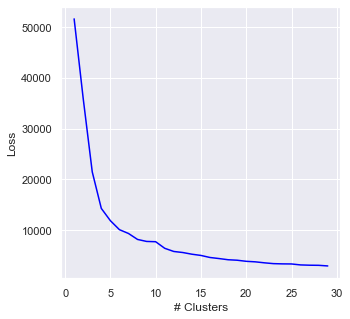

In [22]:
scores = []
clusters = []
for i in tqdm.tqdm(range(1, 30)):
    pca = PCA(n_components=2)
    embedded_x = pca.fit_transform(X)
    kmeans = MiniBatchKMeans(n_clusters=i, init='k-means++', max_iter=1000, batch_size=10000, compute_labels=True, random_state=SEED)
    kmeans.fit(embedded_x)
    score = kmeans.score(embedded_x)
    clusters.append(i)
    scores.append(-score)
df = pd.DataFrame({
    '# Clusters' : clusters,
    'Loss' : scores
})
sns.lineplot(data=df, x='# Clusters', y='Loss', color='blue')

100%|██████████| 29/29 [00:17<00:00,  1.64it/s]


<AxesSubplot:xlabel='# Clusters', ylabel='Loss'>

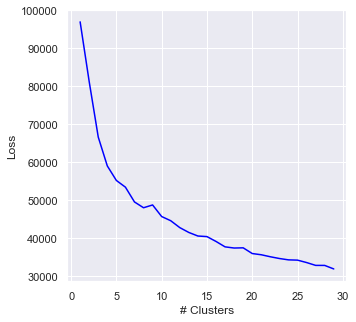

In [7]:
scores = []
clusters = []
for i in tqdm.tqdm(range(1, 30)):
    kmeans = MiniBatchKMeans(n_clusters=i, init='k-means++', max_iter=1000, batch_size=10000, compute_labels=True, random_state=SEED)
    kmeans.fit(X)
    score = kmeans.score(X)
    clusters.append(i)
    scores.append(-score)
df = pd.DataFrame({
    '# Clusters' : clusters,
    'Loss' : scores
})
sns.lineplot(data=df, x='# Clusters', y='Loss', color='blue')
    



In [8]:
kmeans = MiniBatchKMeans(n_clusters=7, init='k-means++', max_iter=1000, batch_size=10000, compute_labels=True, random_state=SEED)
kmeans.fit(X)
kmeansDF = pd.DataFrame({
    'HR' : hr,
    'BR' : br,
    'Posture' : posture,
    'Activity' : activity,
    'Cluster' : kmeans.labels_,
    'Y' : y
})


In [37]:
def plot_side_by_side(cluster_num):
    pca = PCA(n_components=2)
    embedded_X = pca.fit_transform(X)
    kmeans = MiniBatchKMeans(n_clusters=cluster_num, init='k-means++', max_iter=1000, batch_size=10000, compute_labels=True, random_state=SEED)
    kmeans.fit(embedded_X)
    df = pd.DataFrame({
        'pca0' : embedded_x[:, 0],
        'pca1' : embedded_x[:, 1],
        'Cluster' : kmeans.labels_,
        'Label' : [int(item) for item in y]
    })
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
    fig.suptitle('Cluster & Label Comparison')

    sns.scatterplot(ax=axes[0], data=df, x='pca0', y='pca1', hue='Cluster', palette="mako")
    axes[0].set_title('Cluster')

    sns.scatterplot(ax=axes[1], data=df, x='pca0', y='pca1', hue='Label', palette="mako")
    axes[1].set_title('Label')
    plt.savefig('cluster_vs_label_%i.pdf' % cluster_num, format='pdf')



In [ ]:
# g = sns.PairGrid(kmeansDF, vars=["HR", "BR", "Posture", "Activity"], hue='Cluster', palette="Blues")
# g.map_diag(sns.histplot)
# g.map_offdiag(sns.scatterplot, size=kmeansDF['Y'])
# g.add_legend()
# # sns.scatterplot(data=test_df, x='HR', y='BR', hue='Cluster', style='Y')

In [9]:
# g = sns.PairGrid(kmeansDF, vars=["HR", "BR", "Posture", "Activity"], hue='Cluster', palette="Blues")
# g.map_diag(sns.histplot)
# g.map_offdiag(sns.scatterplot, size=kmeansDF['Y'])
# g.add_legend()
# # sns.scatterplot(data=test_df, x='HR', y='BR', hue='Cluster', style='Y')

In [10]:
# X_embedded = TSNE(n_components=2).fit_transform(X)

# sns.scatterplot(data=test_df, x='HR', y='BR', hue='Cluster', style='Y')

In [41]:
skf = StratifiedKFold(n_splits=FOLDS)
precision = []
recall = []
f1 = []
accuracy = []

for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    pca = PCA(n_components=2)
    embedded_X = pca.fit_transform(X_train)
    # kmeans = MiniBatchKMeans(n_clusters=NUM_CLASSES, init='k-means++', max_iter=1000, batch_size=10000, compute_labels=True, random_state=SEED)
    kmeans = MiniBatchKMeans(n_clusters=5, init='k-means++', max_iter=1000, batch_size=10000, compute_labels=True, random_state=SEED)
    print('Fitting %i...' % fold)
    kmeans.fit(embedded_X)
    print('Scoring %i...' % fold)
    # Now that the model is fit, assign each centroid's label to be the dominant class (we're really just hoping this lines up with y)
    centroid_to_class_counters = defaultdict(lambda : Counter())
    for i in range(len(X_train)):
        centroid_label = kmeans.labels_[i]
        true_label = y_train[i]
        centroid_to_class_counters[centroid_label][true_label] += 1
    centroid_to_label = {}
    for centroid, counter in centroid_to_class_counters.items():
        centroid_to_label[centroid] = counter.most_common(1)[0][0]

    centroid_preds = kmeans.predict(pca.transform(X_test))
    y_pred = np.array([centroid_to_label[centroid] for centroid in centroid_preds])
    y_true = y_test

    precision.append(precision_score(y_true, y_pred, average='macro', zero_division=0))
    recall.append(recall_score(y_true, y_pred, average='macro'))
    f1.append(f1_score(y_true, y_pred, average='macro'))
    accuracy.append(accuracy_score(y_true, y_pred))

    # Do timing on last iteration
    if TEST_LATENCY and fold == FOLDS - 1:
        predict_func = lambda val : centroid_to_label[kmeans.predict([val])[0]]
        latency(predict_func, X_test, iters=100000)

df = pd.DataFrame({
    'precision' : precision,
    'recall' : recall,
    'f1' : f1,
    'accuracy' : accuracy
})
print(df)
df.mean()

Fitting 0...
Scoring 0...
Fitting 1...
Scoring 1...
Fitting 2...
Scoring 2...
Fitting 3...
Scoring 3...
Fitting 4...
Scoring 4...
Fitting 5...
Scoring 5...
Fitting 6...
Scoring 6...
Fitting 7...
Scoring 7...
Fitting 8...
Scoring 8...
Fitting 9...
Scoring 9...
   precision    recall        f1  accuracy
0   0.065700  0.134360  0.083531  0.275633
1   0.068450  0.137407  0.086049  0.281955
2   0.066975  0.135601  0.084553  0.278512
3   0.067872  0.136900  0.085652  0.280670
4   0.070210  0.139239  0.087787  0.285244
5   0.070207  0.139496  0.087801  0.286015
6   0.069180  0.138817  0.087171  0.284114
7   0.066745  0.136150  0.084765  0.279180
8   0.066498  0.136317  0.084895  0.278783
9   0.067181  0.136855  0.085295  0.280479


precision    0.067902
recall       0.137114
f1           0.085750
accuracy     0.281059
dtype: float64

In [ ]:
plot_side_by_side(10)